# Разработка модели прогнозирования объемов добычи нефти в регионе, а также последующий анализ потенциальной прибыли и рисков

Цель данного исследования заключается в разработке и построении эффективной модели машинного обучения для определения оптимального региона для бурения новой нефтяной скважины. Исследование направлено на максимизацию прибыли от добычи нефти в условиях трех различных регионов.


**Описание данных:**

**df**
- `geo_data_0` - данные по первому региону.
- `geo_data_1` - данные по второму региону.
- `geo_data_2` - данные по третьему региону.

**Данные**
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — признаки скважины;
- `product` — объём запасов в скважине в тыс. баррелей(целевой признак).

**Этапы работы**

1. [Загрузка и подготовка данных](#Загрузка-и-подготовка-данных)
2. [Обучение и проверка модели](#Обучение-и-проверка-модели)
3. [Подготовка к расчёту прибыли](#Подготовка-к-расчёту-прибыли)
4. [Расчёт прибыли и рисков](#Расчёт-прибыли-и-рисков)
5. [Общий вывод](#Общий-вывод)
    

In [1]:
!pip install -U scikit-learn -q

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [18]:
RANDOM_STATE = 17
STATE = np.random.RandomState(17)
EXPLORE_POINTS = 500
BEST_POINTS = 200
BUDGET = 1e+10
ONE_BURREL_INCOME = 450000

In [4]:
def oil_well_pred(df):
    """
    Обучает модель регрессии для прогнозирования добычи нефти на основе
    предоставленных данных обучения и проверяет ее на валидационных данных.

    Параметры:
    - df: DataFrame, содержащий данные для обучения.

    Возвращает:
    - best_model: Лучшая обученная модель на основе случайного поиска.
    - pred_valid: Таблица с прогнозируемыми и фактическими значениями валидационной выборки.
    - rmse_train: RMSE на обучающих данных.
    - rmse_valid: RMSE на валидационных данных.
    - r2_train: R2 на обучающих данных.
    - r2_valid: R2 на валидационных данных.
    """  
    
    X = df.drop('product', axis=1)
    y = df['product']

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y,
        test_size=0.25,
        random_state=RANDOM_STATE)
    
    num_columns = ['f0', 'f1', 'f2']

    data_preprocessor = ColumnTransformer(
        [('num', MinMaxScaler(), num_columns)], 
        remainder='passthrough')
    
    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())])
    
    param_grid = {
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    }
    
    randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,)
    
    randomized_search.fit(X_train, y_train)
    
    best_model = randomized_search.best_estimator_
    y_valid_pred = randomized_search.predict(X_valid)
    
    rmse_train = randomized_search.best_score_ * -1
    rmse_valid = mean_squared_error(y_valid, y_valid_pred, squared=False)
    
    y_train_pred = best_model.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    r2_valid = r2_score(y_valid, y_valid_pred)
    
    pred_valid = pd.DataFrame(y_valid)
    pred_valid['pred'] = y_valid_pred

    
    return best_model, pred_valid, rmse_train, rmse_valid, r2_train, r2_valid


def plotting_correlations(df):
    """
    Визуализирует распределение целевого признака, матрицы диаграмм рассеяния
    и выводит матрицу корреляции Пирсона.

    Параметры:
    - df: DataFrame, содержащий данные для визуализации.

    """  

    plt.figure(figsize=(10, 6))
    sns.histplot(df['product'], kde=False, bins=15)
    plt.title('Гистограмма распределения product')
    plt.ylabel('Кол-во')
    plt.show()
    sns.pairplot(df.sample(frac=0.1, random_state=RANDOM_STATE), kind='kde')
    plt.suptitle('Матрица диаграмм рассеяния', y=1.02)
    plt.show()
    display(df.corr().style.background_gradient(cmap='Greens'))

## Загрузка и подготовка данных

### Загрузка данных

In [5]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    print('There is no such file')
    
try:
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    print('There is no such file')
    
try:
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    print('There is no such file')

In [6]:
display(data_0.sample(5))
data_0.info()
print()
print(f'Количество пропусков в данных: {data_0.isna().sum().sum()}')

,id,f0,f1,f2,product
25646,21ZYe,1.192912,0.027394,5.943848,156.331388
73397,Cv9We,1.108999,-0.537337,1.562836,128.946500
70126,ZxR2S,1.938836,-0.143816,-1.289772,136.371181
83142,Ep6Sd,-1.050937,0.065496,0.214876,50.066262
18395,8oUlM,-0.035303,0.413030,9.332618,167.662794


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество пропусков в данных: 0


In [7]:
display(data_1.sample(5))
data_1.info()
print()
print(f'Количество пропусков в данных: {data_1.isna().sum().sum()}')

,id,f0,f1,f2,product
94090,t3ils,4.574291,-2.341536,0.999046,26.953261
75321,ameGs,4.944411,-8.583324,3.001171,80.859783
77294,4GE0X,-1.345909,-9.921307,3.000866,84.038886
2723,5IYXq,7.248711,-1.637847,0.996033,26.953261
57816,Hzkn2,-1.831653,-7.229645,2.001922,53.906522


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество пропусков в данных: 0


In [8]:
display(data_2.sample(5))
data_2.info()
print()
print(f'Количество пропусков в данных: {data_2.isna().sum().sum()}')

,id,f0,f1,f2,product
40828,mM4N6,-0.057825,1.054061,-4.579991,4.464282
18216,vqMOn,2.707717,-1.012323,9.629847,175.204412
13484,amkOO,-1.400901,-1.338281,5.223502,87.099119
12249,R0JJK,2.095866,1.366584,-3.074373,66.668753
36470,23CEu,-1.538099,1.985464,4.421513,82.711740


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество пропусков в данных: 0


В предоставленных данных отсутствуют пропуски, и все переменные загружены с соответствующими корректными типами данных.

### Проверка данных на наличие дубликатов

**Явные дубликаты**

In [9]:
for i in ['data_0', 'data_1', 'data_2']:
    print(f'Явные дубликаты в {i}: {globals()[i].duplicated().sum()}')

Явные дубликаты в data_0: 0
Явные дубликаты в data_1: 0
Явные дубликаты в data_2: 0


**Неявные дубликаты**

In [10]:
for i in ['data_0', 'data_1', 'data_2']:
    print(f'Неявные дубликаты по id в {i}: {globals()[i].duplicated(subset=["id"], keep=False).sum()}')

Неявные дубликаты по id в data_0: 20
Неявные дубликаты по id в data_1: 8
Неявные дубликаты по id в data_2: 8


In [11]:
for i in [data_0, data_1, data_2]:
    i.drop_duplicates(subset=['id'], inplace=True)

In [12]:
for i in ['data_0', 'data_1', 'data_2']:
    globals()[i].set_index('id', inplace=True)
    print(f'Не явные дубликаты по признакам в {i}: {globals()[i].duplicated().sum()}')

Не явные дубликаты по признакам в data_0: 0
Не явные дубликаты по признакам в data_1: 0
Не явные дубликаты по признакам в data_2: 0


Были обнаружены и устранены неявные дубликаты по id скважин.

### Исследовательский анализ данных

**data_0**

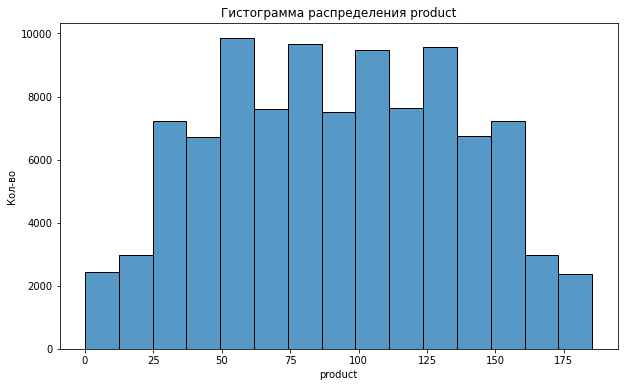

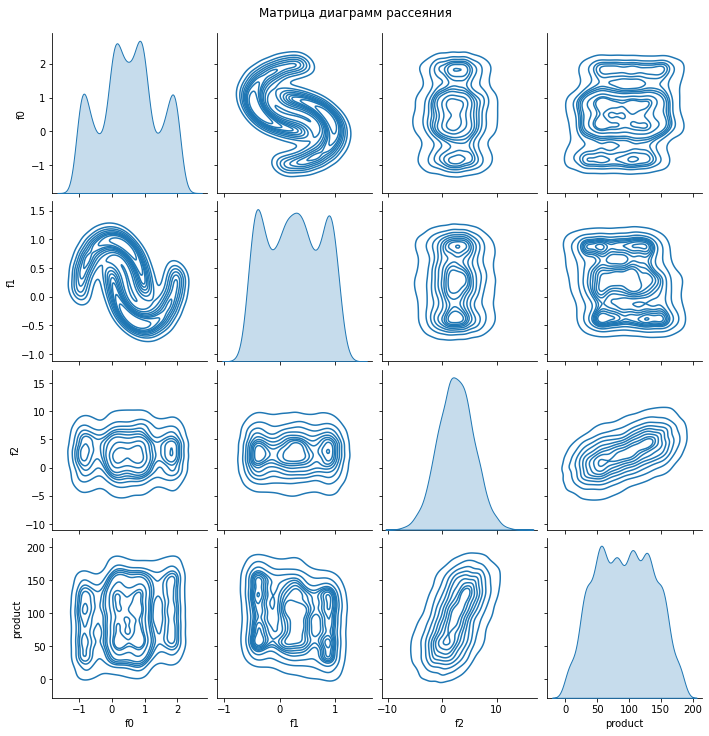

,f0,f1,f2,product
f0,1.000000,-0.440717,-0.003211,0.143504
f1,-0.440717,1.000000,0.001764,-0.192351
f2,-0.003211,0.001764,1.000000,0.483631
product,0.143504,-0.192351,0.483631,1.000000


In [52]:
plotting_correlations(data_0)

- Для показателей `f0`, `f1` и `product` наблюдается выраженная полимодальность и симметричность распределений, в то время как показатель `f2` характеризуется нормальным распределением.
- Взаимосвязи показателей с целевым признаком нелинейны.
- Показатель `f2` демонстрирует наивысший коэффициент корреляции Пирсона(0.48) с объемами нефти.

**data_1**

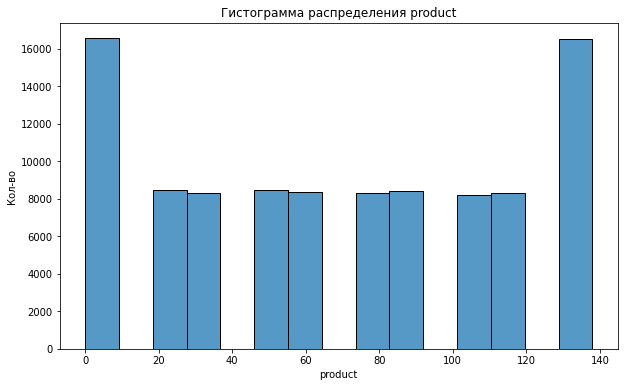

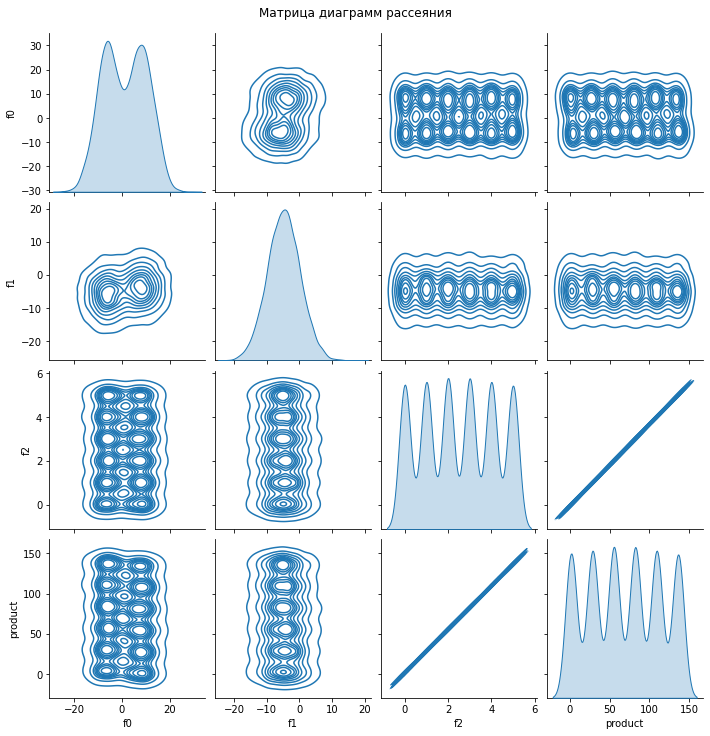

,f0,f1,f2,product
f0,1.000000,0.182279,-0.001810,-0.030523
f1,0.182279,1.000000,-0.002594,-0.010154
f2,-0.001810,-0.002594,1.000000,0.999397
product,-0.030523,-0.010154,0.999397,1.000000


In [53]:
plotting_correlations(data_1)

- Для показателей `f0`, `f2` и `product` наблюдается выраженная полимодальность и симметричность распределений, в то время как показатель `f1` характеризуется нормальным распределением.
- Мы можем отметить прямую и линейную зависимость между показателем f2 и целевым признаком.
- Показатель `f2` демонстрирует наивысший коэффициент корреляции Пирсона(0.99) с объемами нефти.

**data_2**

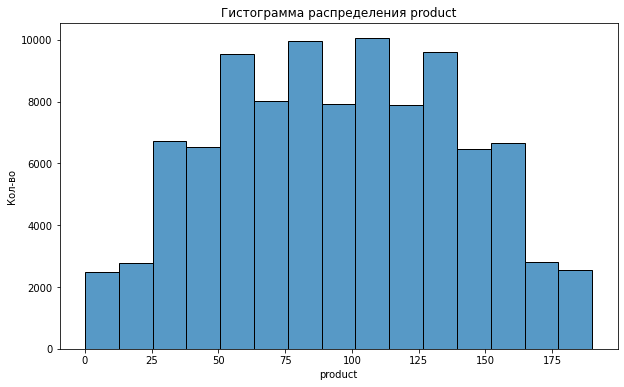

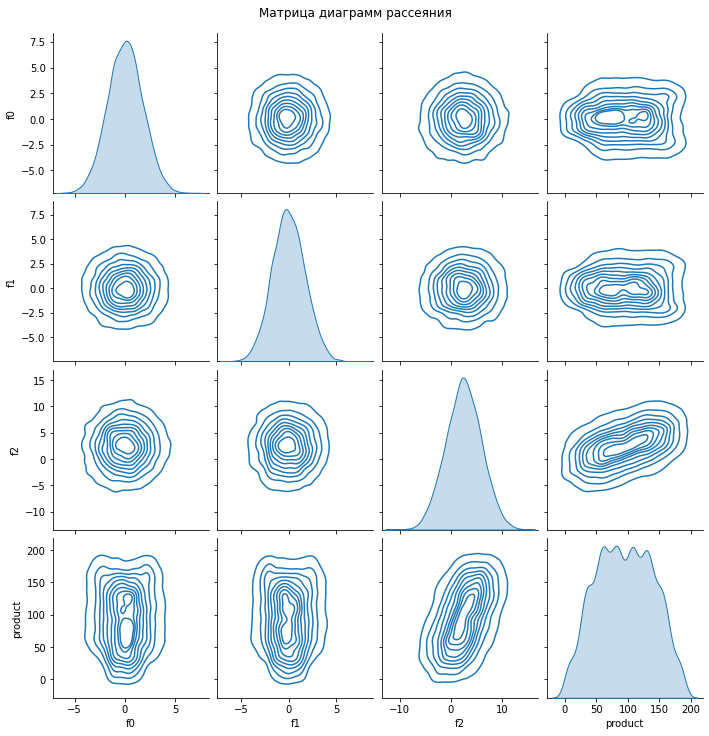

,f0,f1,f2,product
f0,1.000000,0.000506,-0.000452,-0.001978
f1,0.000506,1.000000,0.000753,-0.001055
f2,-0.000452,0.000753,1.000000,0.445867
product,-0.001978,-0.001055,0.445867,1.000000


In [54]:
plotting_correlations(data_2)

- Все показатели имеют нормальное распределение.
- Взаимосвязи показателей с целевым признаком нелинейны.
- Показатель `f2` демонстрирует наивысший коэффициент корреляции Пирсона(0.44) с объемами нефти.

**Мы можем заметить сходство в распределении целевого признака между нулевым и вторым регионами.**

**Выводы:**
- Мы успешно загрузили данные, не выявив пропусков. Тем не менее, были обнаружены и устранены неявные дубликаты по идентификаторам скважин.
- Столбец `id` (уникальный идентификатор скважины) был установлен в качестве индексов для наблюдений.
- В каждом из признаков наблюдается ярко выраженная симметричность распределений.
- Показатель `f2` обладает наивысшим коэффициентом корреляции Пирсона с целевым признаком в каждом из регионов.
- Во втором регионе можно отметить прямую и линейную зависимость между показателем `f2` и целевым признаком.
- Можно отметить сходство в распределении целевого признака между нулевым и вторым регионами.
- Исходя из результатов исследовательского анализа, можно предположить, что данные могут иметь синтетическое происхождение.

## Обучение и проверка модели

### Обучение моделей

**data_0**

In [13]:
best_model_0, pred_valid_0, rmse_train_0, rmse_valid_0, r2_train_0, r2_valid_0 =\
    oil_well_pred(data_0)

**data_1**

In [14]:
best_model_1, pred_valid_1, rmse_train_1, rmse_valid_1, r2_train_1, r2_valid_1 =\
    oil_well_pred(data_1)

**data_2**

In [15]:
best_model_2, pred_valid_2, rmse_train_2, rmse_valid_2, r2_train_2, r2_valid_2 =\
    oil_well_pred(data_2)

### Анализ результатов

In [16]:
pivot = pd.DataFrame({'region': ['Регион 0', 'Регион 1', 'Регион 2'],
                      'average_oil_stock': [pred_valid_0['pred'].mean(), pred_valid_1['pred'].mean(),
                                            pred_valid_2['pred'].mean()],
                      'rmse_train': [rmse_train_0, rmse_train_1, rmse_train_2],
                      'rmse_valid':[rmse_valid_0, rmse_valid_1, rmse_valid_2],
                      'r2_train': [r2_train_0, r2_train_1, r2_train_2],
                      'r2_valid': [r2_valid_0, r2_valid_1, r2_valid_2]
                     })

In [17]:
pivot.sort_values(by=['r2_valid'], ascending=False).set_index('region')

,average_oil_stock,rmse_train,rmse_valid,r2_train,r2_valid
region,,,,,
Регион 1,68.857569,0.891268,0.887809,0.999625,0.999624
Регион 0,92.561848,37.726494,37.593297,0.274587,0.278939
Регион 2,94.862079,40.062519,40.037957,0.197425,0.202878


**Вывод:**
- На валидационной выборке наилучшие результаты показала модель, обученная на данных первого региона. Её среднеквадратичное отклонение равняется 0.89, в то время, как коэффициент детерминации достиг значения 0.99. Такие результаты могут быть объяснены наличием выраженной линейной зависимости, а также корреляцией Пирсона равной 0.99 между признаком `f2` и целевой переменной. Средний запас предсказанного сырья равняется 68.8 тыс. баррелей.
- Отсутствие линейных взаимосвязей между показателями и целевым признаком во втором и нулевом регионах привело к существенному снижению качества моделей по сравнению с первым регионом. Для нулевого региона значение rmse составлил 37.59, а средний прогнозируемый объем запасов сырья равен 92.56 тысячам баррелей. В случае второго региона rmse равен 40.03, а средний прогнозируемый объем запасов сырья составляет 94.86 тысяч баррелей. Эти показатели указывают на менее эффективное предсказание моделей в сравнении с первым регионом.
- Предсказанные результаты и фактическиt значениями валидационной выборки мы сохранили в переменные `pred_valid_0`, `pred_valid_1` и `pred_valid_2`.

## Подготовка к расчёту прибыли

### Рассчет достаточного объёма сырья для безубыточной разработки новой скважины

In [20]:
break_even_volume = BUDGET / (BEST_POINTS * ONE_BURREL_INCOME)
print(f'Объёма сырья для безубыточной разработки скважины: {round(break_even_volume, 2)} тысяч баррелей.')

Объёма сырья для безубыточной разработки скважины: 111.11 тысяч баррелей.


### Сравнение объёма сырья для безубыточной разработки скважины и среднего запаса в каждом регионе.

In [21]:
for indx, data in enumerate([data_0, data_1, data_2]):
    print(f'{f"Средний запас в data_{indx}"}: {round(data["product"].mean(), 2)}')
    print(f'Процент скважин с объёмом не меньше чем порог = {round(len(data.query("product >= @break_even_volume"))/len(data) * 100, 2)}%\n')
    

Средний запас в data_0: 92.5
Процент скважин с объёмом не меньше чем порог = 36.58%

Средний запас в data_1: 68.82
Процент скважин с объёмом не меньше чем порог = 16.54%

Средний запас в data_2: 95.0
Процент скважин с объёмом не меньше чем порог = 38.18%



In [23]:
print(f'Необходимый процент скважин с достаточным объемом: {BEST_POINTS / EXPLORE_POINTS * 100}%')

Необходимый процент скважин с достаточным объемом: 40.0%


**Вывод:**
- Объёма сырья для безубыточной разработки скважины: 111.11 тысяч баррелей.
- В каждом из регионов не достигнут требуемый уровень процента подходящих скважин. Для обеспечения окупаемости инвестиций в разработку, выбранные моделью скважины должны обладать объемом сырья, превышающим установленное пороговое значение.

## Расчёт прибыли и рисков 

### Рассчет прибыли для каждого региона

In [28]:
def revenue(target, probabilities):
    probs_sorted = probabilities.sort_values(ascending=False)[:BEST_POINTS]
    selected = target[probs_sorted.index]
    return selected.sum() * ONE_BURREL_INCOME - BUDGET

In [30]:
print(f'Прибыль для 0 региона: {revenue(pred_valid_0["product"], pred_valid_0["pred"]) / 100000000}')
print(f'Прибыль для 1 региона: {revenue(pred_valid_1["product"], pred_valid_1["pred"]) / 100000000}')
print(f'Прибыль для 2 региона: {revenue(pred_valid_2["product"], pred_valid_2["pred"]) / 100000000}')

Прибыль для 0 региона: 31.99651367188593
Прибыль для 1 региона: 24.15086696681511
Прибыль для 2 региона: 23.582598013458405


### Применение Bootstrap, для нахождения  распределение прибыли.

In [26]:
for indx, region in enumerate([pred_valid_0, pred_valid_1, pred_valid_2]):    
    values = []
    
    for _ in range(1000):
        target_subsample = region['pred'].sample(explore_points, replace=True, random_state = state)
        probs_subsample = region['product'][target_subsample.index]
        values.append(revenue(probs_subsample, target_subsample))
        
    
    values = pd.Series(values)
            
    mean = values.mean() / 10000000
    lower = values.quantile(.025) / 10000000
    upper = values.quantile(.975) / 10000000
    risk = values.apply(lambda x: x < 0).sum() / len(values) * 100
    
    print(f'Регион {indx}:')
    print(f'Средняя прибыль с 200 лучших скважин - {round(mean, 2)} млн.руб.')
    print(f'95%-й доверительный интервал от {round(lower, 2)} до {round(upper, 2)}')
    print(f'Риск - {risk}%.\n')

Регион 0:
Средняя прибыль с 200 лучших скважин - 64.66 млн.руб.
95%-й доверительный интервал от 5.41 до 125.99
Риск - 1.9%.

Регион 1:
Средняя прибыль с 200 лучших скважин - 64.34 млн.руб.
95%-й доверительный интервал от 14.37 до 121.33
Риск - 0.4%.

Регион 2:
Средняя прибыль с 200 лучших скважин - 52.84 млн.руб.
95%-й доверительный интервал от -6.88 до 115.16
Риск - 3.8%.



**Вывод:**

Наиболее оптимальным решением будет выбор первого региона. Данный регион отличается низким уровнем риска, составляющим 0.4%. Кроме того, он обладает высокой средней прибылью в размере 64.34 миллиона, а максимальная возможная прибыль достигает 121.33 миллиона. 

## Общий вывод
### Загрузка и подготовка данных
- Мы успешно загрузили данные, пропуски не обнаруженны. Однако были обнаружены и устранены неявные дубликаты по id скважин.
- В каждом из признаков наблюдается ярко выраженная симметричность распределений.
- Показатель `f2` обладает наивысшим коэффициентом корреляции Пирсона с целевым признаком в каждом из регионов.
- Во втором регионе можно отметить прямую и линейную зависимость между показателем `f2` и целевым признаком

### Обучение моделей
- На валидационной выборке наилучшие результаты показала модель, обученная на данных первого региона. Её среднеквадратичное отклонение равняется 0.890280, в то время, как коэффициент детерминации достиг значения 0.999625. Такие результаты могут быть объяснены наличием выраженной линейной зависимости, а также корреляцией Пирсона равной 0.99 между признаком `f2` и целевой переменной. Средний запас предсказанного сырья равняется 68.7 тыс. баррелей.
- Отсутствие линейных взаимосвязей между показателями и целевым признаком во втором и нулевом регионах привело к существенному снижению качества моделей по сравнению с первым регионом. Для нулевого региона значение rmse составлил 37.75, а средний прогнозируемый объем запасов сырья равен 92.39 тысячам баррелей. В случае второго региона rmse равен 40.14, а средний прогнозируемый объем запасов сырья составляет 94.77 тысяч баррелей. Эти показатели указывают на менее эффективное предсказание моделей в сравнении с первым регионом.

### Подготовка к расчёту прибыли
- Объёма сырья для безубыточной разработки скважины: 111.11 тысяч баррелей.
- В каждом из регионов не достигнут требуемый уровень процента подходящих скважин. Для обеспечения окупаемости инвестиций в разработку, выбранные моделью скважины должны обладать объемом сырья, превышающим установленное пороговое значение.

### Расчёт прибыли и рисков
- Наиболее оптимальным выбором при рассмотрении регионов является первый регион. В данном случае наблюдается низкий уровень риска, который составляет 0.4%. Кроме того, этот регион характеризуется высокой средней прибылью в размере 64.34 миллиона, а максимальная возможная прибыль достигает 121.33 миллиона. 